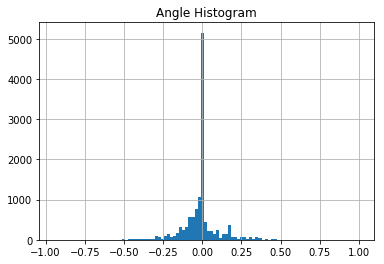

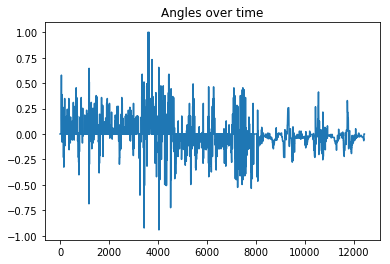

In [2]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from pylab import rcParams, imshow
import cv2
import numpy as np
import collections
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

origin_image_shape = (160, 320, 3)
data_dir = "data/"

def read_driving_log(csv_file = data_dir +'driving_log.csv'):
    return pd.read_csv(csv_file)

       
def plot_steering_angles(angles):
    plt.hist(angles, bins=100)
    plt.title("Angle Histogram")
    plt.grid(True)
    plt.plot()
    plt.show();


driving_log = read_driving_log()

plot_steering_angles(driving_log["steering"])


plt.plot(driving_log["steering"])
plt.title("Angles over time")
plt.show();

The above image shows the histogram of steering angles. From the histogram we can observe that the overwhelming majority of angels are zero. How many are exactly zero ?

In [16]:
driving_log["steering"].count()
angles = driving_log["steering"]
nonzero_angles = angles[angles > 0.0].count()
zero_angles = angles[angles == 0.0].count()

print("Angle bigger than zero   : {}".format(nonzero_angles))
print("Angle equal to zero      : {}".format(zero_angles))
print("% of zero angles         : {:.2f}".format(zero_angles / (nonzero_angles + zero_angles) * 100))

Angle bigger than zero   : 2583
Angle equal to zero      : 4529
% of zero angles         : 63.68


Here are a couple of helper functions for image augmentation:

In [3]:
def read_image(filename):
    image =  mpimg.imread(filename)
    return image

def flip(image, angle):
    image = np.array(image)
    flipped = cv2.flip(image, 1)
    angle = -angle
    return flipped, angle
    
def crop(image):
    image = image[66:130, 70:230]
    return image

def random_select_lcr(image_locations, augment):
    lrc_select = np.random.randint(3)
    # if augmentation is turned off, we always choose the center image
    if augment == False:
        lrc_select = 1
        
    angle = image_locations.get("steering")
    
    deps = {0 : ("left", angle + 0.25),
            1 : ("center", angle),
            2 : ("right", angle -0.25)
           }
    direction, angle_shift = deps[lrc_select]
    path_file = image_locations.get(direction).strip()
    return direction, angle_shift, path_file
    
def jitter(img):
    # see https://stackoverflow.com/questions/35152636/random-flipping-and-rgb-jittering-slight-value-change-of-image
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    RGBshifted = np.dstack( (
        np.roll(R, 10, axis=0), 
        np.roll(G, 10, axis=1), 
        np.roll(B, -10, axis=0)
        ))
    return RGBshifted

def rand_brightness(img):
    # taken from https://github.com/vxy10/ImageAugmentation
    image1 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def normalize(img):
    return (img - 128.) / 128.
    
def display_image_grid(images, cols, rows):
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(18, 10))
    fig.suptitle('Augmented Images', fontsize=20)
    
    for i in range(rows):
        for j in range(cols):
            if len(images) > i+j:
                direction, angle, img = images[i+j]
                ax[i][j].imshow(img)
                ax[i][j].text(0, -20, "{}, angle:{:.2f}".format(direction, angle), size=10, rotation=0,
                        ha="left", va="top", 
                        bbox=dict(boxstyle="round", ec= (0, .6, .1), fc=(1, 1, 1)))
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show();

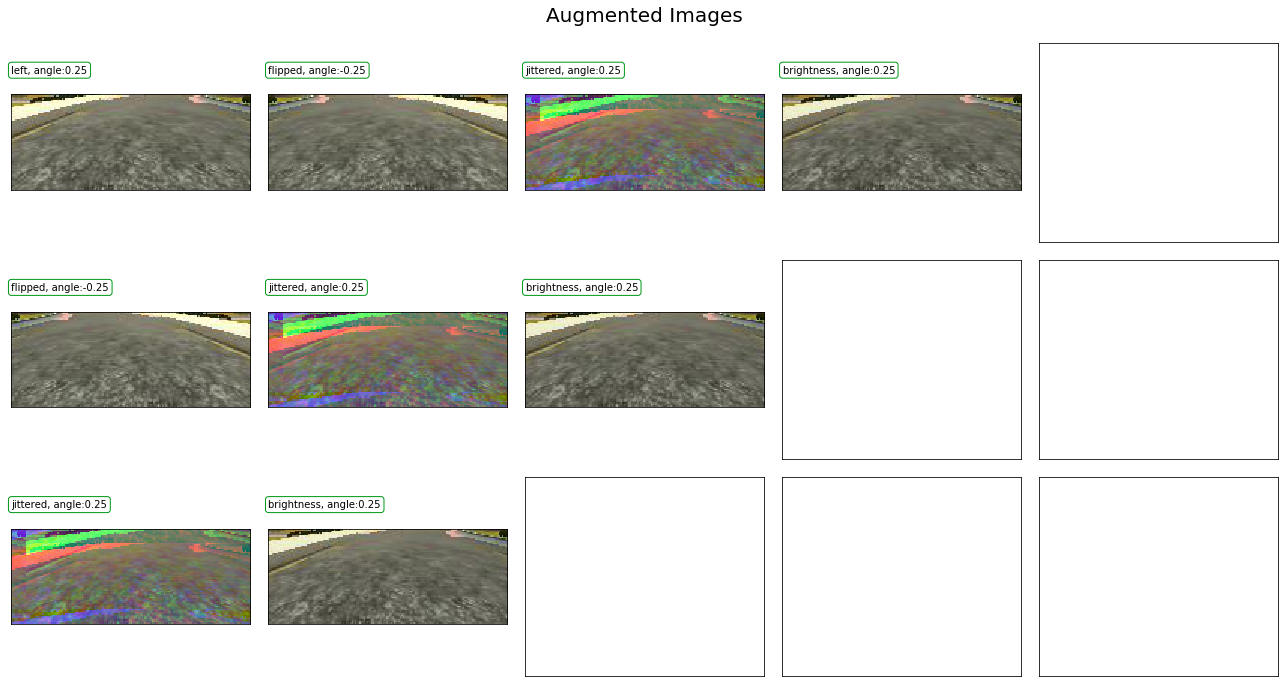

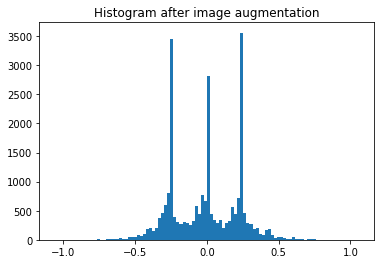

In [4]:
def image_processing_step(sample, keep_probability=1, angle_threshold=0.01, augment=False):
    images = []
    path_to_center_image = sample.get("center")
    angle_of_center_image = sample.get("steering")
    if abs(angle_of_center_image) <= angle_threshold and np.random.uniform() > keep_probability:
        return images
    
    # randomly select center, right or left image and adjust angle by (-) 0.25 if not center
    direction, angle, img_path = random_select_lcr(sample, augment)
    original_image = crop(read_image(data_dir + img_path))
    images.append((direction, angle, original_image))

    if augment == True:
        # flip image horizontally if angle > 0
        if np.random.uniform() >= 0.5 and abs(angle) > 0.0:
            flipped, flipped_angle = flip(original_image, angle)
            images.append(("flipped", flipped_angle, flipped))

        # add jitter
        if np.random.uniform() >= 0.5:
            jittered = jitter(original_image)
            images.append(("jittered", angle, jittered))

        # adjust random brightness
        if np.random.uniform() >= 0.5:
            random_b = rand_brightness(original_image)
            images.append(("brightness", angle, random_b))

    return images
    
    
train, test = train_test_split(driving_log, test_size = 0.2)
sample = train.sample(1)
pr = []
for index, row in sample.iterrows():
    pr.extend(image_processing_step(row, augment=True))

display_image_grid(pr, 5, 3 )

samples = train.sample(frac=1)
processed = []
for index, row in samples.iterrows():
    pr = image_processing_step(row, augment=True)
    if len(pr) != 0:
        processed.extend(pr)

direction, y_train, X_train = zip(*processed)
X_train = np.array(X_train)
y_train = np.array(y_train)


test_images_path = np.array(test["center"])
X_test = []
for i in range(0,len(test_images_path)):
    X_test.append(crop(read_image(data_dir + test_images_path[i])))

X_test = np.array(X_test)
y_test = np.array(test["steering"])


plt.hist(y_train, bins=100);
plt.title("Histogram after image augmentation")
plt.show;



Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 78, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 37, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 17, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 15, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 13, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 832)               0         
__________

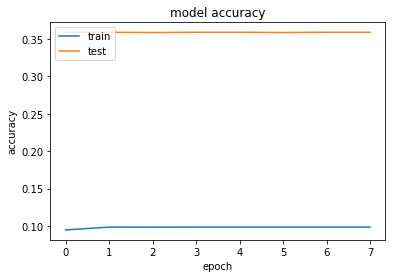

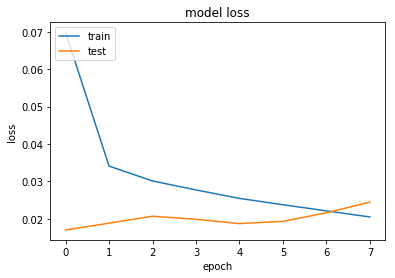

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Convolution2D, Cropping2D, Activation, Dropout, BatchNormalization, ELU, \
    AveragePooling2D,  ZeroPadding2D
from keras.layers.pooling import MaxPooling2D


img_shape = (64,160,3)

def NVIDIA():
    # NVIDIA Model, as per https://arxiv.org/pdf/1604.07316.pdf, but with ELU
    model = Sequential()
    model.add(Lambda(lambda x: ((x - 128.) / 128.), input_shape=img_shape))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='elu', strides=(1, 1)))
    model.add(Conv2D(64, (3, 3), activation='elu', strides=(1, 1)))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dropout(.5))
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(.2))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1, activation='tanh'))
    return model


model = NVIDIA()
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            shuffle=True,
            epochs=8,
            verbose=1,
            batch_size=256)

model.save('model.h5')

# plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

